# Assessing quality of assemblies
There are assemblies for nine samples being assessed here.

These samples have >= 30x coverage of PacBio CCS. As well as good coverage Illumina and Nanopore.

There are five assembly tools being analysed, with an assembly for each Nanopore and PacBio. Except for Spades, which takes all sequencing technologies at once.

The polishing is done in two steps:
1. Polish assembly with the long reads it was made from using `racon`
2. Polish the output of `racon` with Illumina using `pilon` until there is no more changes made to the assembly.

In [3]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from collections import defaultdict
from dataclasses import dataclass

sns.set_style("darkgrid")
FIGSIZE = (13, 8)

In [4]:
@dataclass
class Sample:
    name: str
    assembler: str
    technology: str
    is_polished: bool
    
    @staticmethod
    def from_path(path: Path) -> "Sample":
        parts = path.parts
        is_polished = "polished" in path.name
        return Sample(
            name = parts[-5],  # we index from end in case starting path is further up dirtree
            assembler = parts[-4],
            technology = parts[-3],
            is_polished = is_polished
        )

In [7]:
assessment_files = list(Path().rglob("*.json"))

In [8]:
len(assessment_files)

162

In [9]:
data = []

In [10]:
for file in assessment_files:
    sample = Sample.from_path(file)
    arr = [
        sample.name,
        sample.assembler,
        sample.technology,
        sample.is_polished,
    ]
    d = json.loads(file.read_text())
    mapq = d["mapping_quality_stats"]
    pileup = d["pileup_stats"]
    arr.extend([
        pileup["percent_pileup_disagree"],
        pileup["total_disagreements"],
        pileup["total_pileup_positions"],
        [
            mapq["min"], mapq["25%"], mapq["50%"], mapq["75%"], mapq["max"]
        ],
        mapq["mean"],
        mapq["std"]
    ])
    data.append(arr)

In [11]:
columns = [
    "sample",
    "assembler",
    "technology",
    "is_polished",
    "disagree_rate",
    "disagreements",
    "total_positions",
    "mapq_percentiles",
    "mapq_mean",
    "mapq_stdev"
]

In [187]:
df = pd.DataFrame(data, columns=columns)
h37rv_len = 4411532
df["relative_total_length"] = np.absolute((df["total_positions"] - h37rv_len) / 1000)

# Disagreement rate
The first metric we will look at is disagreement rate. This is a "proxy" for per-base accuracy of our assemblies. As we don't have a ground-truth for these samples, we need some kind of metric that gives us an indication of the accuracy.  
Disagreement rate is calculated by mapping Illumina reads (with `bwa mem`) for a given sample to the unpolished and polished assemblies of that sample.

## Plot sample disagreement rate

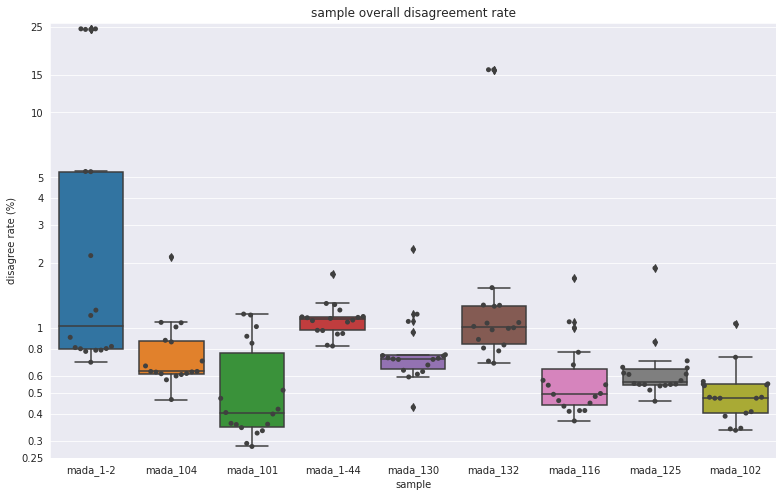

In [113]:
fig, ax = plt.subplots(figsize=FIGSIZE)
ax = sns.boxplot(
    x="sample", 
    y="disagree_rate", 
    data=df, 
    ax=ax
)
ax = sns.swarmplot(
    x="sample", 
    y="disagree_rate", 
    data=df, 
    ax=ax,
    dodge=True,
    color="0.25"
)
ax.set(title="sample overall disagreement rate")
ax.set_yscale("log")
ax.set_ylabel("disagree rate (%)")
log_ticks = [0.25, 0.3, 0.4, 0.5, 0.6, 0.8, 1, 2, 3, 4, 5, 10, 15, 25]
ax.set_yticks(log_ticks)
_ = ax.set_yticklabels(log_ticks)
_ = ax.set_ylim((0.25, 26))


## Plot sample (un)polished disagreement rate


(0.25, 26)

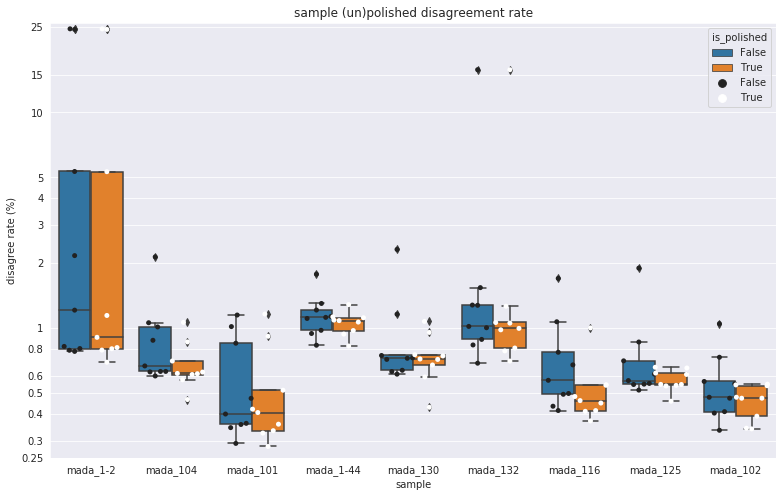

In [45]:
fig, ax = plt.subplots(figsize=FIGSIZE)
ax = sns.boxplot(
    x="sample", 
    y="disagree_rate", 
    data=df, 
    hue="is_polished", 
    ax=ax
)
ax = sns.swarmplot(
    x="sample", 
    y="disagree_rate", 
    data=df, 
    hue="is_polished", 
    ax=ax,
    dodge=True,
    color="white"
)
ax.set_yscale("log")
ax.set(title="sample (un)polished disagreement rate")
ax.set_ylabel("disagree rate (%)")
log_ticks = [0.25, 0.3, 0.4, 0.5, 0.6, 0.8, 1, 2, 3, 4, 5, 10, 15, 25]
ax.set_yticks(log_ticks)
_ = ax.set_yticklabels(log_ticks)
_ = ax.set_ylim((0.25, 26))

So, on the whole, polishing reduces the disagreement rate - phew!


(0.25, 26)

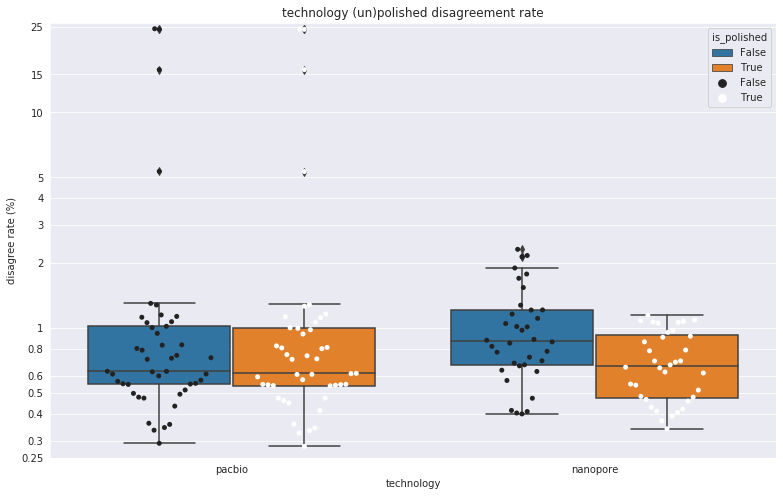

In [44]:
fig, ax = plt.subplots(figsize=FIGSIZE)
ax = sns.boxplot(
    x="technology", 
    y="disagree_rate", 
    data=df, 
    hue="is_polished", 
    ax=ax
)
ax = sns.swarmplot(
    x="technology", 
    y="disagree_rate", 
    data=df, 
    hue="is_polished", 
    ax=ax,
    dodge=True,
    color="white"
)
ax.set_yscale("log")
ax.set(title="technology (un)polished disagreement rate")
ax.set_ylabel("disagree rate (%)")
log_ticks = [0.25, 0.3, 0.4, 0.5, 0.6, 0.8, 1, 2, 3, 4, 5, 10, 15, 25]
ax.set_yticks(log_ticks)
_ = ax.set_yticklabels(log_ticks)
_ = ax.set_ylim((0.25, 26))

In [188]:
polished_df = df.query("is_polished == True")

## Plot disagreement rate for each assembler

(0.25, 26)

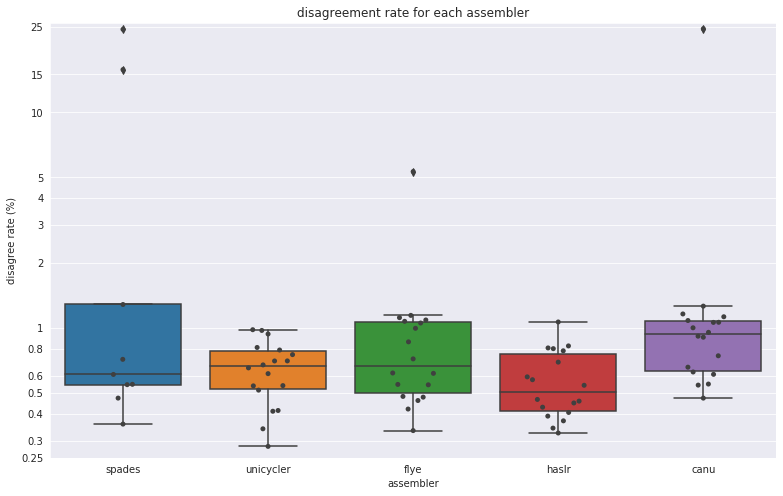

In [50]:
fig, ax = plt.subplots(figsize=FIGSIZE)
ax = sns.boxplot(
    x="assembler", 
    y="disagree_rate", 
    data=polished_df, 
    ax=ax
)
ax = sns.swarmplot(
    x="assembler", 
    y="disagree_rate", 
    data=polished_df, 
    ax=ax,
    dodge=True,
    color="0.25"
)
ax.set_yscale("log")
ax.set(title="disagreement rate for each assembler")
ax.set_ylabel("disagree rate (%)")
log_ticks = [0.25, 0.3, 0.4, 0.5, 0.6, 0.8, 1, 2, 3, 4, 5, 10, 15, 25]
ax.set_yticks(log_ticks)
_ = ax.set_yticklabels(log_ticks)
_ = ax.set_ylim((0.25, 26))

## Plot disagreement rate for each assembler, split by technology

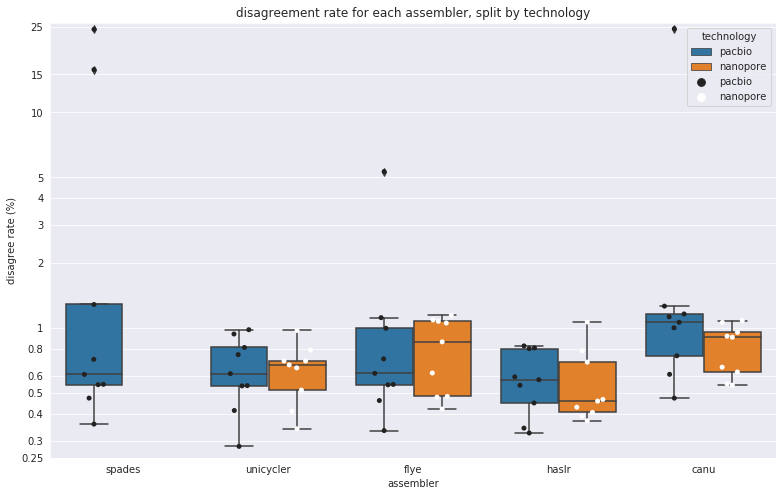

In [52]:
fig, ax = plt.subplots(figsize=FIGSIZE)
ax = sns.boxplot(
    x="assembler", 
    y="disagree_rate", 
    hue="technology",
    data=polished_df, 
    ax=ax
)
ax = sns.swarmplot(
    x="assembler", 
    y="disagree_rate", 
    hue="technology",
    data=polished_df, 
    ax=ax,
    dodge=True,
    color="white"
)
ax.set_yscale("log")
ax.set(title="disagreement rate for each assembler, split by technology")
ax.set_ylabel("disagree rate (%)")
log_ticks = [0.25, 0.3, 0.4, 0.5, 0.6, 0.8, 1, 2, 3, 4, 5, 10, 15, 25]
ax.set_yticks(log_ticks)
_ = ax.set_yticklabels(log_ticks)
_ = ax.set_ylim((0.25, 26))

![confused](https://i.imgflip.com/1dpyce.jpg)

Ok..... Wasn't expecting that!

Let's filter out the two "bad" quality samples

## Plot disagreement rate for each assembler, split by technology (without `mada_1-2` and `mada_132`)

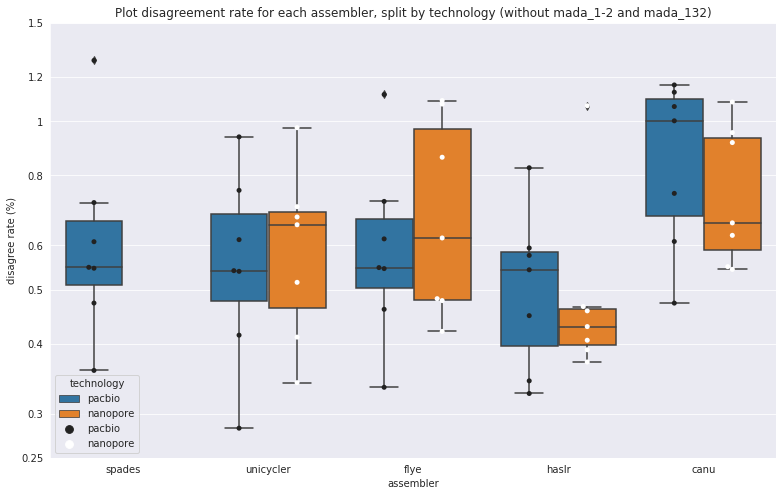

In [58]:
fig, ax = plt.subplots(figsize=FIGSIZE)
ax = sns.boxplot(
    x="assembler", 
    y="disagree_rate", 
    hue="technology",
    data=polished_df.query("sample != 'mada_1-2' & sample != 'mada_132'"), 
    ax=ax
)
ax = sns.swarmplot(
    x="assembler", 
    y="disagree_rate", 
    hue="technology",
    data=polished_df.query("sample != 'mada_1-2' & sample != 'mada_132'"), 
    ax=ax,
    dodge=True,
    color="white"
)
ax.set_yscale("log")
ax.set(title="Plot disagreement rate for each assembler, split by technology (without mada_1-2 and mada_132)")
ax.set_ylabel("disagree rate (%)")
log_ticks = [0.25, 0.3, 0.4, 0.5, 0.6, 0.8, 1, 1.2, 1.5]
ax.set_yticks(log_ticks)
_ = ax.set_yticklabels(log_ticks)
_ = ax.set_ylim((0.25, 1.5))

So, without those two samples, the assemblers start to like reasonably simialr.

What if we look at each sample split but technology?

## Plot disagreement rate for each sample, split by technology

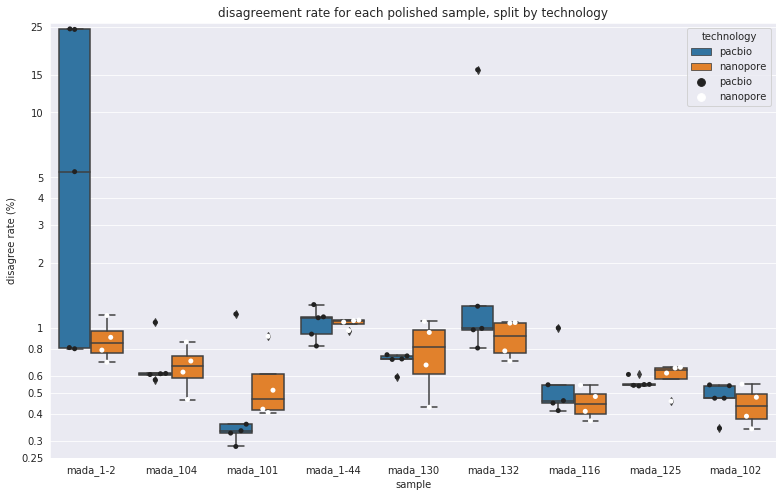

In [68]:
fig, ax = plt.subplots(figsize=FIGSIZE)
ax = sns.boxplot(
    x="sample", 
    y="disagree_rate", 
    hue="technology",
    data=polished_df, 
    ax=ax
)
ax = sns.swarmplot(
    x="sample", 
    y="disagree_rate", 
    hue="technology",
    data=polished_df, 
    ax=ax,
    dodge=True,
    color="white"
)
ax.set(title="disagreement rate for each polished sample, split by technology")
ax.set_yscale("log")
ax.set_ylabel("disagree rate (%)")
log_ticks = [0.25, 0.3, 0.4, 0.5, 0.6, 0.8, 1, 2, 3, 4, 5, 10, 15, 25]
ax.set_yticks(log_ticks)
_ = ax.set_yticklabels(log_ticks)
_ = ax.set_ylim((0.25, 26))

It seems like the nanopore data is much more consistent than the Pacbio. However, if 
you disregard the two "bad" quality samples, it isn't too drastically different.  

Let's have a look at the same plot, but the unpolished data.

## Plot disagreement rate for each sample (**unpolished**), split by technology


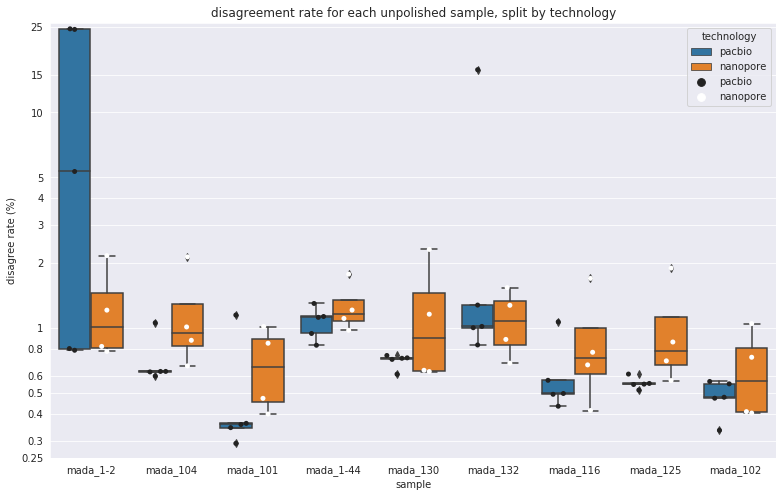

In [71]:
fig, ax = plt.subplots(figsize=FIGSIZE)
ax = sns.boxplot(
    x="sample", 
    y="disagree_rate", 
    hue="technology",
    data=df.query("is_polished == False"), 
    ax=ax
)
ax = sns.swarmplot(
    x="sample", 
    y="disagree_rate", 
    hue="technology",
    data=df.query("is_polished == False"), 
    ax=ax,
    dodge=True,
    color="white"
)
ax.set(title="disagreement rate for each unpolished sample, split by technology")
ax.set_yscale("log")
ax.set_ylabel("disagree rate (%)")
log_ticks = [0.25, 0.3, 0.4, 0.5, 0.6, 0.8, 1, 2, 3, 4, 5, 10, 15, 25]
ax.set_yticks(log_ticks)
_ = ax.set_yticklabels(log_ticks)
_ = ax.set_ylim((0.25, 26))

Ok, so moral of the story: PacBio (CCS) assemblies are better than nanopore if you can't polish.

Back to the polished data.

Let's have a look at each assembler, split by sample

## Plot disagreement rate for each assembler, split by sample

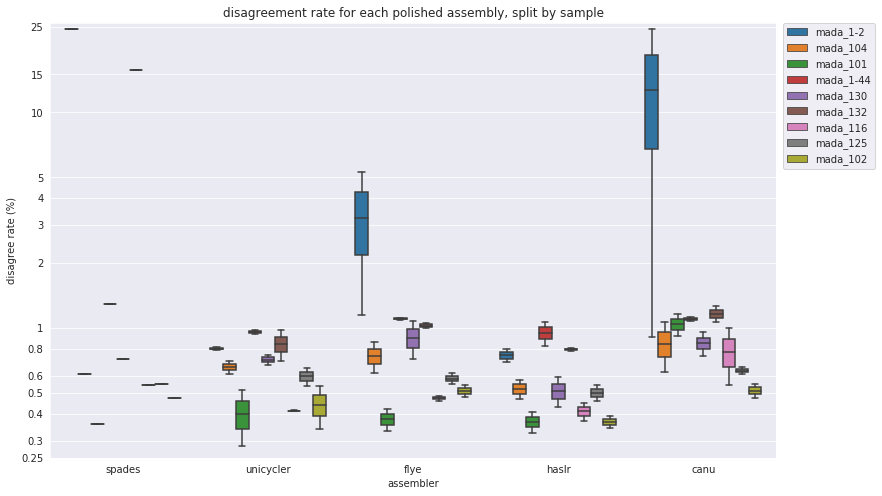

In [88]:
fig, ax = plt.subplots(figsize=FIGSIZE)
ax = sns.boxplot(
    x="assembler", 
    y="disagree_rate", 
    hue="sample",
    data=polished_df, 
    ax=ax
)
ax.set(title="disagreement rate for each polished assembly, split by sample")
ax.set_yscale("log")
ax.set_ylabel("disagree rate (%)")
log_ticks = [0.25, 0.3, 0.4, 0.5, 0.6, 0.8, 1, 2, 3, 4, 5, 10, 15, 25]
ax.set_yticks(log_ticks)
_ = ax.set_yticklabels(log_ticks)
_ = ax.set_ylim((0.25, 26))
# Put the legend out of the figure
_ = plt.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.)

Now we'll try splitting the data by technology and have a look at some of the previous 
plotting combinations.


In [20]:
ont_df = polished_df.query("technology == 'nanopore'")
pb_df = polished_df.query("technology == 'pacbio'")

## One plot to rule them all

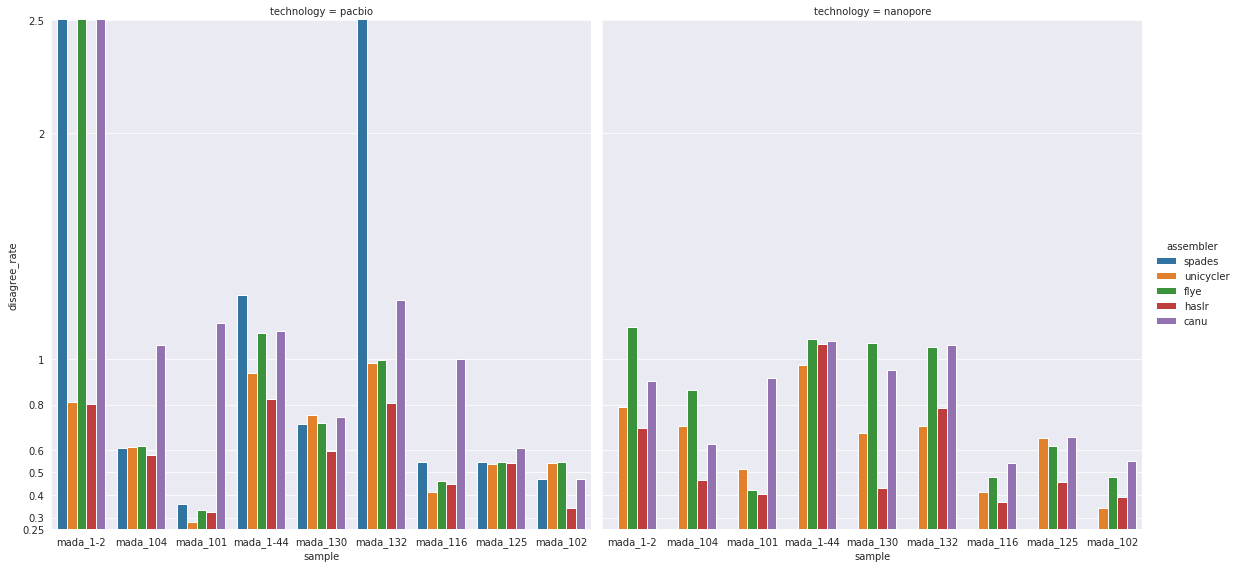

In [228]:
ax = sns.catplot(
    x="sample", 
    y="disagree_rate", 
    hue="assembler",
    col="technology",
    data=polished_df, 
    kind="bar", 
    aspect=1, 
    height=8
)
log_ticks = [0.25, 0.3, 0.4, 0.5, 0.6, 0.8, 1, 2, 2.5]
ax.set(yticks=log_ticks, ylim=(0.25, 2.5))
_ = ax.set_yticklabels(log_ticks)

### Disagreement rate conclusion
...

# Mapping quality statistics
This section will look at the mapping quality scores from the Illumina reads mapped to their respective assemblies.

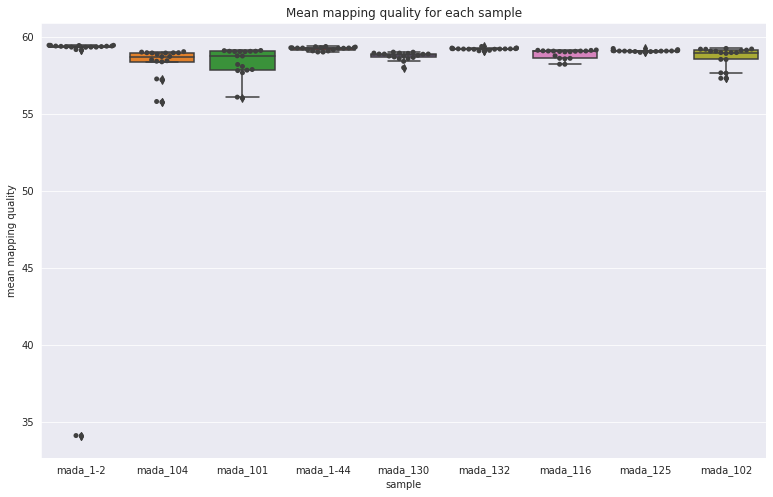

In [115]:
fig, ax = plt.subplots(figsize=FIGSIZE)
ax = sns.boxplot(
    x="sample", 
    y="mapq_mean", 
    data=df, 
    ax=ax
)
ax = sns.swarmplot(
    x="sample", 
    y="mapq_mean", 
    data=df, 
    ax=ax,
    dodge=True,
    color="0.25"
)
ax.set(title="Mean mapping quality for each sample")
_ = ax.set_ylabel("mean mapping quality")

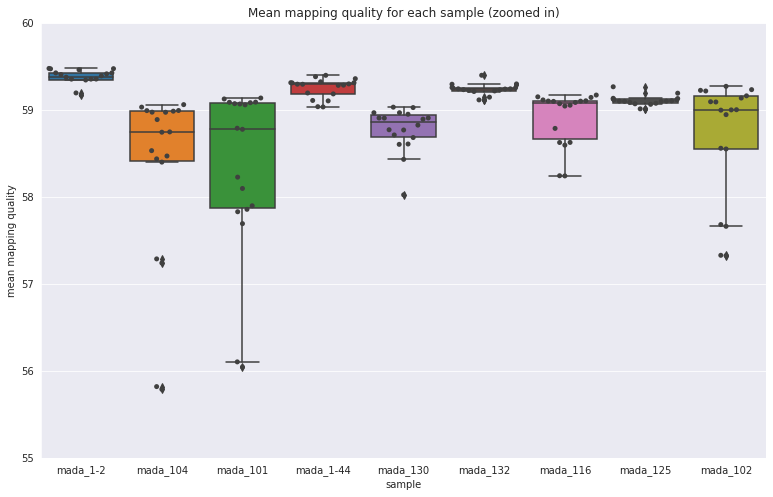

In [117]:
fig, ax = plt.subplots(figsize=FIGSIZE)
ax = sns.boxplot(
    x="sample", 
    y="mapq_mean", 
    data=df, 
    ax=ax
)
ax = sns.swarmplot(
    x="sample", 
    y="mapq_mean", 
    data=df, 
    ax=ax,
    dodge=True,
    color="0.25"
)
ax.set(title="Mean mapping quality for each sample (zoomed in)")
_ = ax.set_ylabel("mean mapping quality")
_ = ax.set_ylim((55, 60))

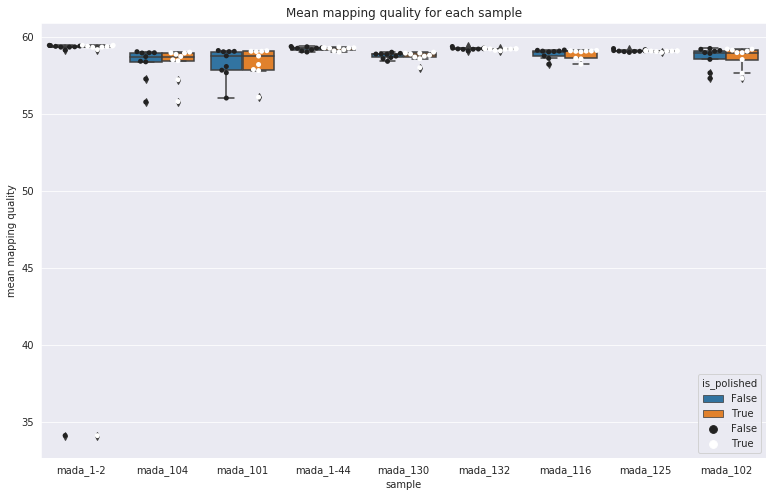

In [121]:
fig, ax = plt.subplots(figsize=FIGSIZE)
ax = sns.boxplot(
    x="sample", 
    y="mapq_mean", 
    hue="is_polished",
    data=df, 
    ax=ax
)
ax = sns.swarmplot(
    x="sample", 
    y="mapq_mean", 
    hue="is_polished",
    data=df, 
    ax=ax,
    dodge=True,
    color="white"
)
ax.set(title="Mean mapping quality for each sample")
_ = ax.set_ylabel("mean mapping quality")

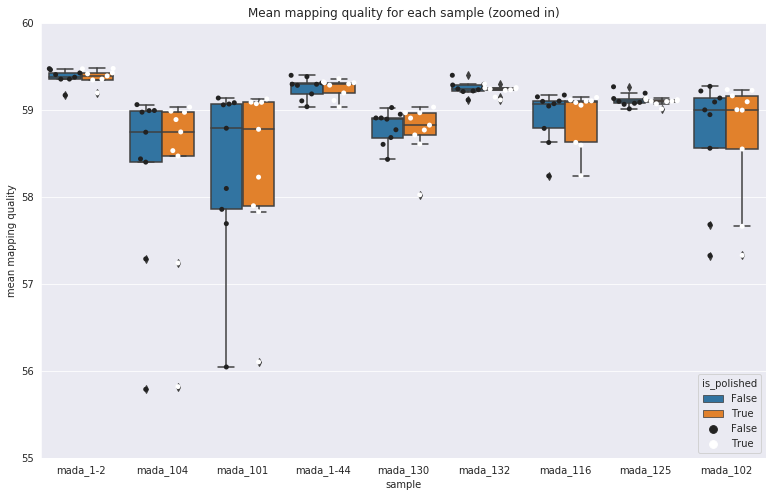

In [122]:
fig, ax = plt.subplots(figsize=FIGSIZE)
ax = sns.boxplot(
    x="sample", 
    y="mapq_mean", 
    hue="is_polished",
    data=df, 
    ax=ax
)
ax = sns.swarmplot(
    x="sample", 
    y="mapq_mean", 
    hue="is_polished",
    data=df, 
    ax=ax,
    dodge=True,
    color="white"
)
ax.set(title="Mean mapping quality for each sample (zoomed in)")
_ = ax.set_ylabel("mean mapping quality")
_ = ax.set_ylim((55, 60))

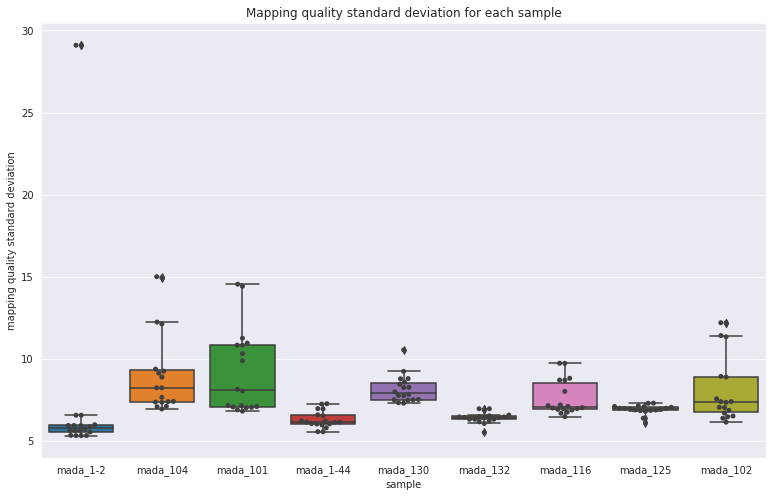

In [120]:
fig, ax = plt.subplots(figsize=FIGSIZE)
ax = sns.boxplot(
    x="sample", 
    y="mapq_stdev", 
    data=df, 
    ax=ax
)
ax = sns.swarmplot(
    x="sample", 
    y="mapq_stdev", 
    data=df, 
    ax=ax,
    dodge=True,
    color="0.25"
)
ax.set(title="Mapping quality standard deviation for each sample")
_ = ax.set_ylabel("mapping quality standard deviation")

# Assembly total length
Relative length here is defined as **the absolute value of the assembly length minus the length of H37Rv**.

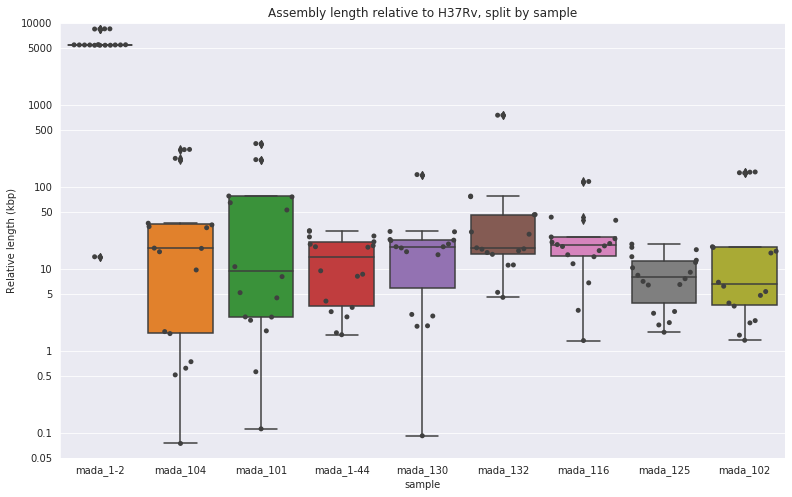

In [186]:
fig, ax = plt.subplots(figsize=FIGSIZE)
ax = sns.boxplot(
    x="sample", 
    y="relative_total_length", 
    data=df, 
    ax=ax
)
ax = sns.swarmplot(
    x="sample", 
    y="relative_total_length", 
    data=df, 
    ax=ax,
    dodge=True,
    color="0.25"
)
ax.set(title="Assembly length relative to H37Rv, split by sample")
_ = ax.set_ylabel("Relative length (kbp)")
ax.set_yscale("log")

log_ticks = [0.05, 0.1, 0.5, 1, 5, 10, 50, 100, 500, 1000, 5000, 10000]
ax.set_yticks(log_ticks)
_ = ax.set_yticklabels(log_ticks)
_ = ax.set_ylim((log_ticks[0], log_ticks[-1]))

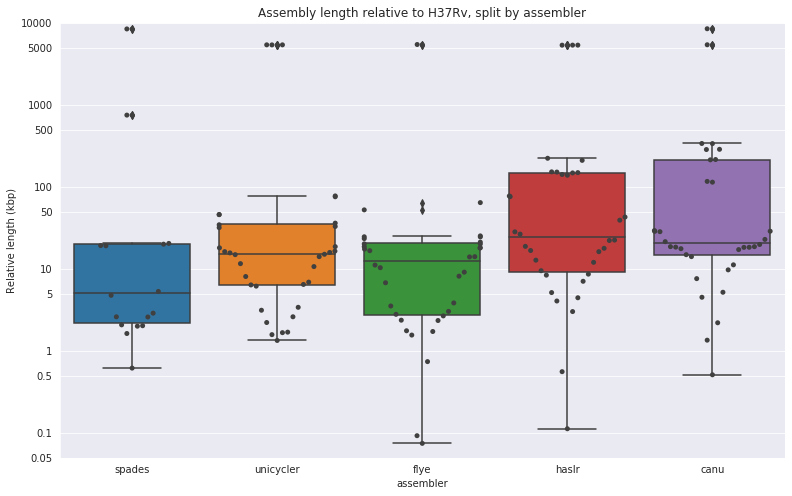

In [185]:
fig, ax = plt.subplots(figsize=FIGSIZE)
ax = sns.boxplot(
    x="assembler", 
    y="relative_total_length", 
    data=df, 
    ax=ax
)
ax = sns.swarmplot(
    x="assembler", 
    y="relative_total_length", 
    data=df, 
    ax=ax,
    dodge=True,
    color="0.25"
)
ax.set(title="Assembly length relative to H37Rv, split by assembler")
_ = ax.set_ylabel("Relative length (kbp)")
ax.set_yscale("log")

log_ticks = [0.05, 0.1, 0.5, 1, 5, 10, 50, 100, 500, 1000, 5000, 10000]
ax.set_yticks(log_ticks)
_ = ax.set_yticklabels(log_ticks)
_ = ax.set_ylim((log_ticks[0], log_ticks[-1]))

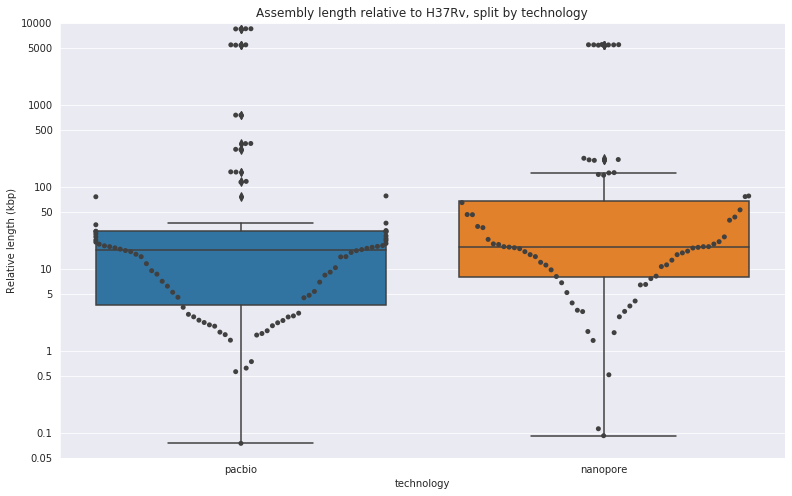

In [184]:
x = "technology"
fig, ax = plt.subplots(figsize=FIGSIZE)
ax = sns.boxplot(
    x=x, 
    y="relative_total_length", 
    data=df, 
    ax=ax
)
ax = sns.swarmplot(
    x=x, 
    y="relative_total_length", 
    data=df, 
    ax=ax,
    dodge=True,
    color="0.25"
)
ax.set(title="Assembly length relative to H37Rv, split by technology")
_ = ax.set_ylabel("Relative length (kbp)")
ax.set_yscale("log")

log_ticks = [0.05, 0.1, 0.5, 1, 5, 10, 50, 100, 500, 1000, 5000, 10000]
ax.set_yticks(log_ticks)
_ = ax.set_yticklabels(log_ticks)
_ = ax.set_ylim((log_ticks[0], log_ticks[-1]))

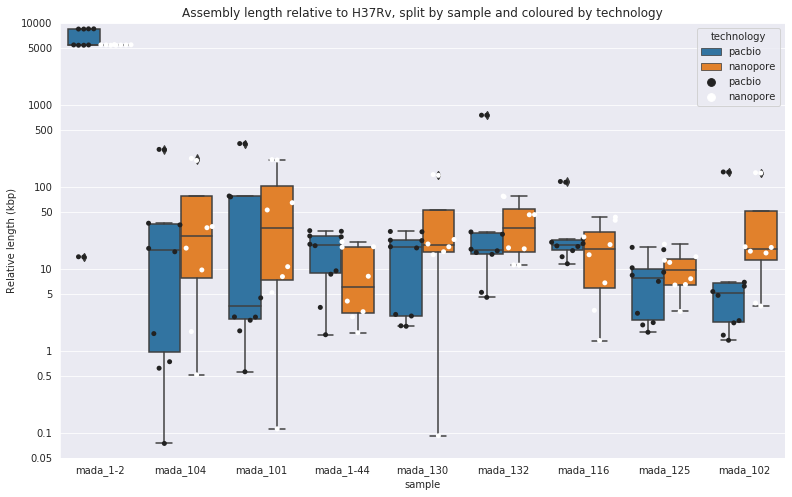

In [183]:
x = "sample"
hue = "technology"
fig, ax = plt.subplots(figsize=FIGSIZE)
ax = sns.boxplot(
    x=x, 
    y="relative_total_length", 
    data=df, 
    hue=hue,
    ax=ax
)
ax = sns.swarmplot(
    x=x, 
    y="relative_total_length", 
    hue=hue,
    data=df, 
    ax=ax,
    dodge=True,
    color="white"
)
ax.set(title="Assembly length relative to H37Rv, split by sample and coloured by technology")
_ = ax.set_ylabel("Relative length (kbp)")
ax.set_yscale("log")

log_ticks = [0.05, 0.1, 0.5, 1, 5, 10, 50, 100, 500, 1000, 5000, 10000]
ax.set_yticks(log_ticks)
_ = ax.set_yticklabels(log_ticks)
_ = ax.set_ylim((log_ticks[0], log_ticks[-1]))

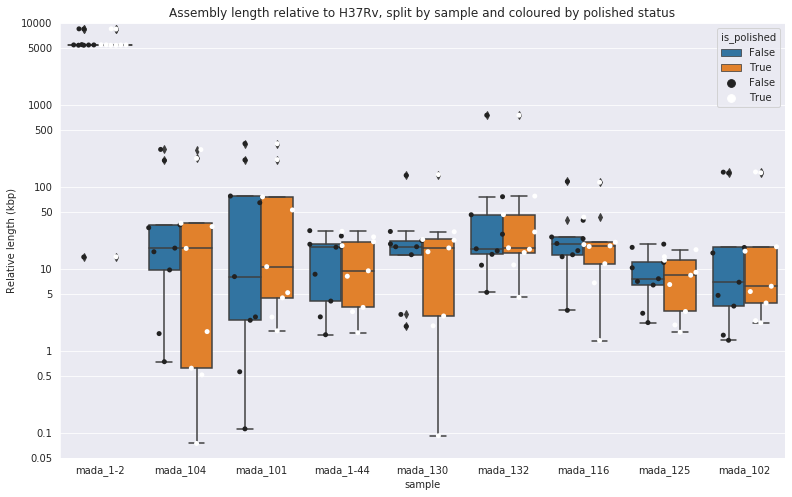

In [182]:
x = "sample"
hue = "is_polished"
fig, ax = plt.subplots(figsize=FIGSIZE)
ax = sns.boxplot(
    x=x, 
    y="relative_total_length", 
    data=df, 
    hue=hue,
    ax=ax
)
ax = sns.swarmplot(
    x=x, 
    y="relative_total_length", 
    hue=hue,
    data=df, 
    ax=ax,
    dodge=True,
    color="white"
)
ax.set(title="Assembly length relative to H37Rv, split by sample and coloured by polished status")
_ = ax.set_ylabel("Relative length (kbp)")
ax.set_yscale("log")

log_ticks = [0.05, 0.1, 0.5, 1, 5, 10, 50, 100, 500, 1000, 5000, 10000]
ax.set_yticks(log_ticks)
_ = ax.set_yticklabels(log_ticks)
_ = ax.set_ylim((log_ticks[0], log_ticks[-1]))

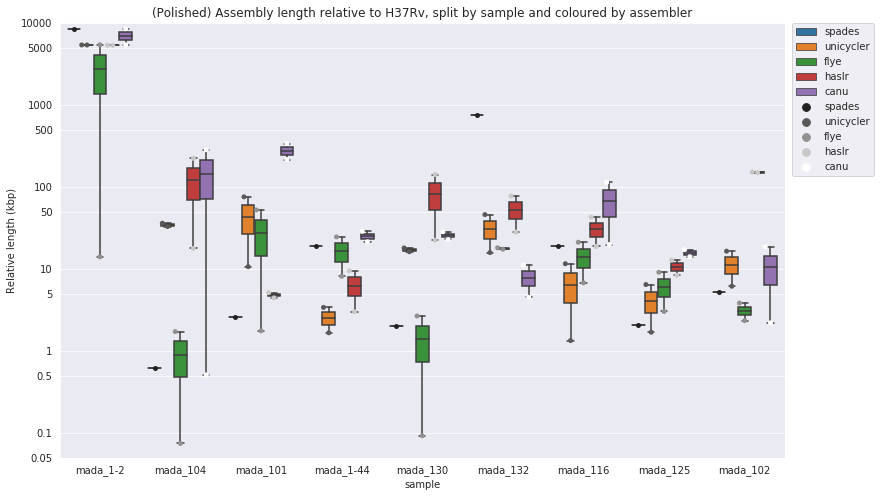

In [193]:
x = "sample"
y= "relative_total_length"
hue = "assembler"
fig, ax = plt.subplots(figsize=FIGSIZE)
ax = sns.boxplot(
    x=x, 
    y=y, 
    data=polished_df, 
    hue=hue,
    ax=ax
)
ax = sns.swarmplot(
    x=x, 
    y=y, 
    hue=hue,
    data=polished_df, 
    ax=ax,
    dodge=True,
    color="white"
)
ax.set(title="(Polished) Assembly length relative to H37Rv, split by sample and coloured by assembler")
_ = ax.set_ylabel("Relative length (kbp)")
ax.set_yscale("log")

log_ticks = [0.05, 0.1, 0.5, 1, 5, 10, 50, 100, 500, 1000, 5000, 10000]
ax.set_yticks(log_ticks)
_ = ax.set_yticklabels(log_ticks)
_ = ax.set_ylim((log_ticks[0], log_ticks[-1]))
# Put the legend out of the figure
_ = plt.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.)

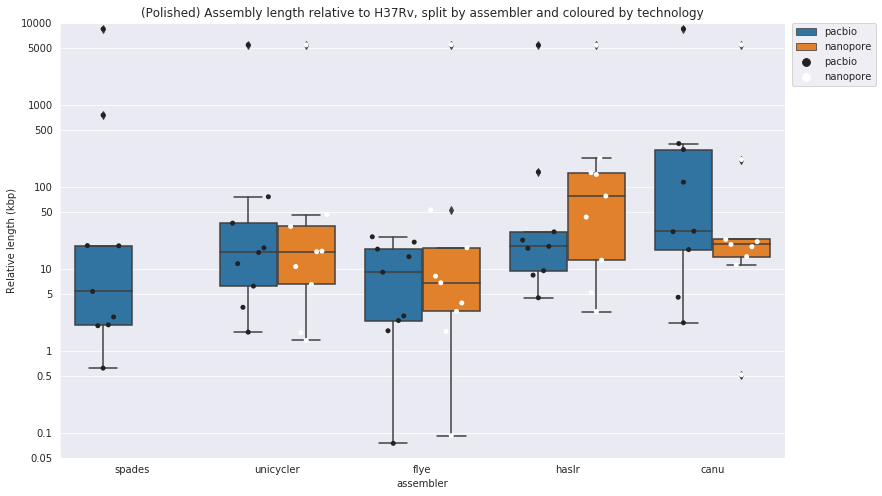

In [205]:
x = "assembler"
y= "relative_total_length"
hue = "technology"
fig, ax = plt.subplots(figsize=FIGSIZE)
ax = sns.boxplot(
    x=x, 
    y=y, 
    data=polished_df, 
    hue=hue,
    ax=ax
)
ax = sns.swarmplot(
    x=x, 
    y=y, 
    hue=hue,
    data=polished_df, 
    ax=ax,
    dodge=True,
    color="white"
)
ax.set(title="(Polished) Assembly length relative to H37Rv, split by assembler and coloured by technology")
_ = ax.set_ylabel("Relative length (kbp)")
ax.set_yscale("log")

log_ticks = [0.05, 0.1, 0.5, 1, 5, 10, 50, 100, 500, 1000, 5000, 10000]
ax.set_yticks(log_ticks)
_ = ax.set_yticklabels(log_ticks)
_ = ax.set_ylim((log_ticks[0], log_ticks[-1]))
# Put the legend out of the figure
_ = plt.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.)

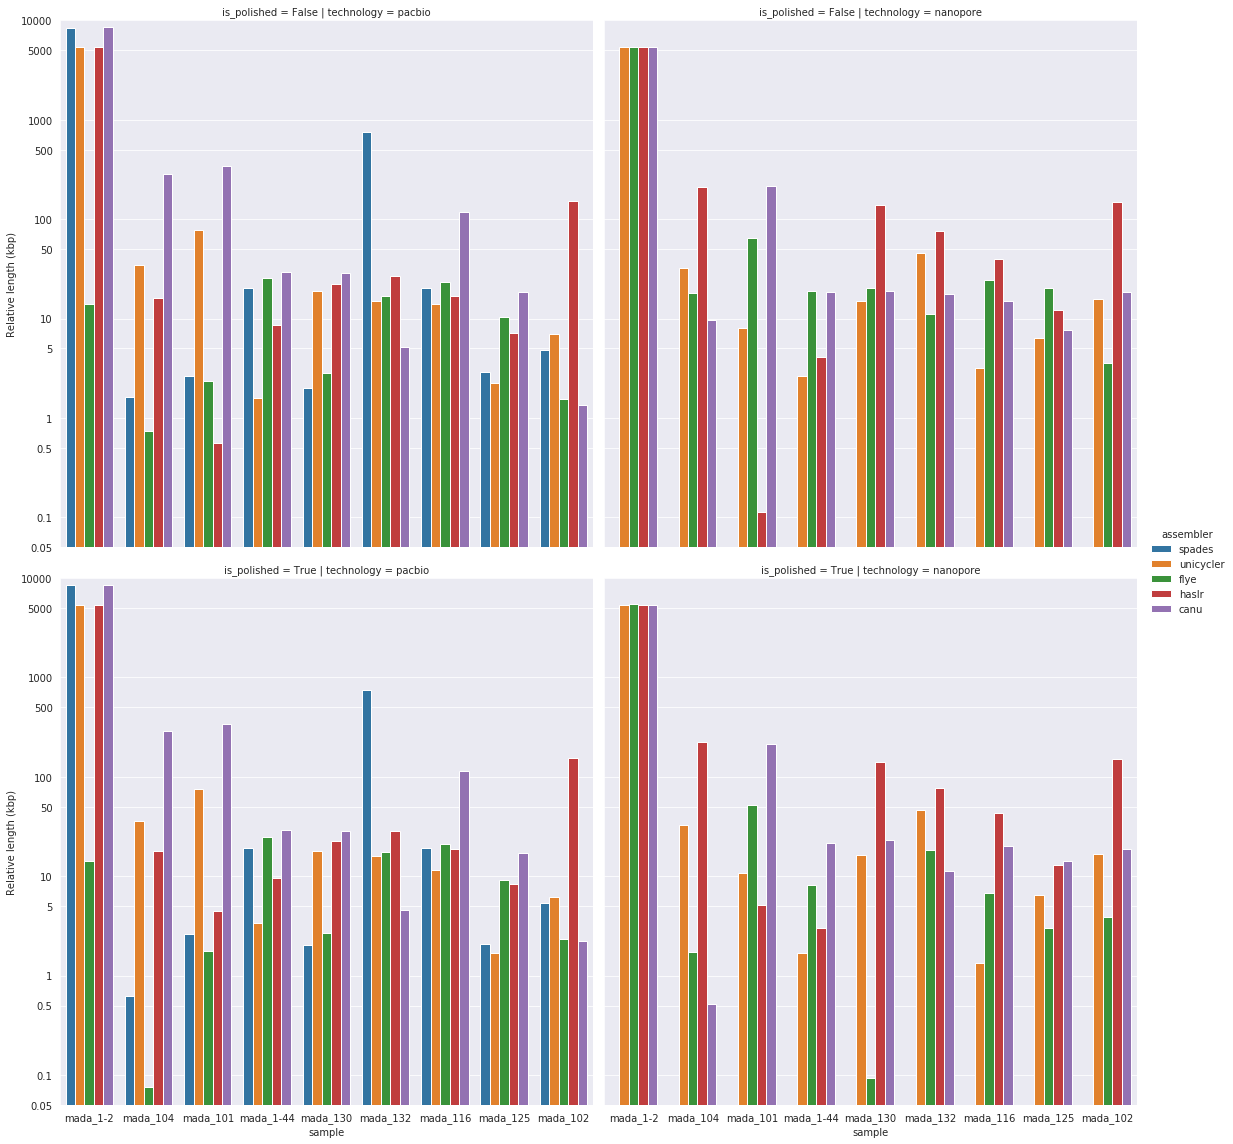

In [204]:
x = "sample"
y = "relative_total_length"
hue = "assembler"
col = "technology"
row = "is_polished"
ax = sns.catplot(
    x=x, 
    y=y, 
    hue=hue,
    row=row,
    col=col,
    data=df, 
    kind="bar", 
    aspect=1, 
    height=8
)
ax.set(yscale="log")
log_ticks = [0.05, 0.1, 0.5, 1, 5, 10, 50, 100, 500, 1000, 5000, 10000]
ylim = (log_ticks[0], log_ticks[-1])
ax.set(yticks=log_ticks, ylim=ylim)
ax.set_axis_labels(x_var=x, y_var="Relative length (kbp)")
_ = ax.set_yticklabels(log_ticks)

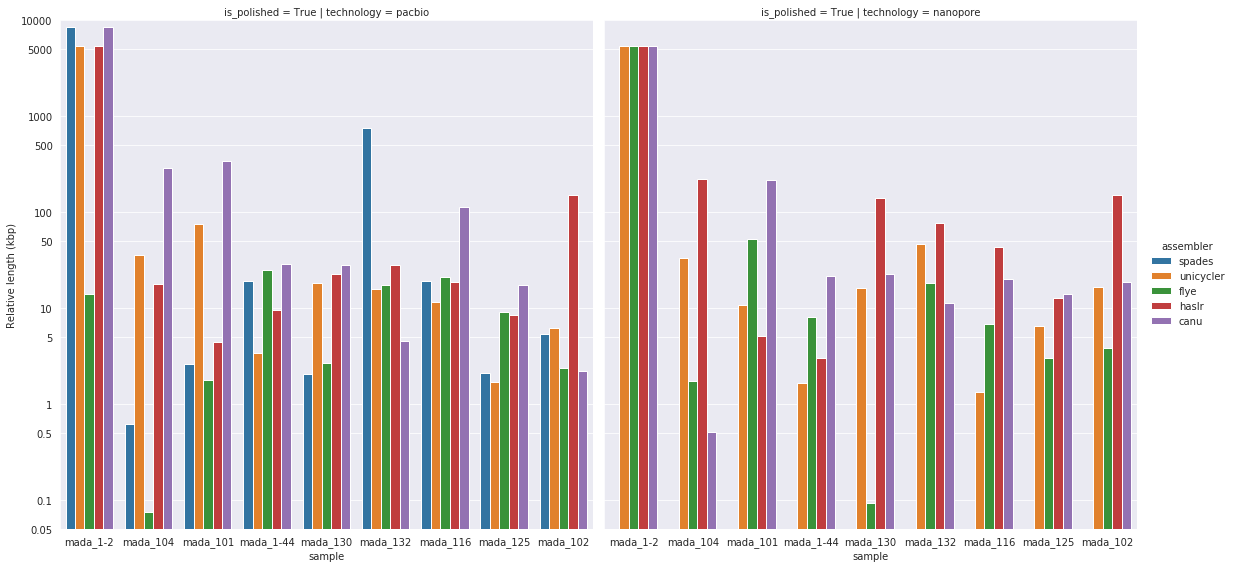

In [203]:
x = "sample"
y = "relative_total_length"
hue = "assembler"
col = "technology"
ax = sns.catplot(
    x=x, 
    y=y, 
    hue=hue,
    row=row,
    col=col,
    data=polished_df, 
    kind="bar", 
    aspect=1, 
    height=8
)
ax.set(yscale="log")
log_ticks = [0.05, 0.1, 0.5, 1, 5, 10, 50, 100, 500, 1000, 5000, 10000]
ylim = (log_ticks[0], log_ticks[-1])
ax.set(yticks=log_ticks, ylim=ylim)
ax.set_axis_labels(x_var=x, y_var="Relative length (kbp)")
_ = ax.set_yticklabels(log_ticks)

In [202]:
help(ax.set_axis_labels)

Help on method set_axis_labels in module seaborn.axisgrid:

set_axis_labels(x_var=None, y_var=None) method of seaborn.axisgrid.FacetGrid instance
    Set axis labels on the left column and bottom row of the grid.



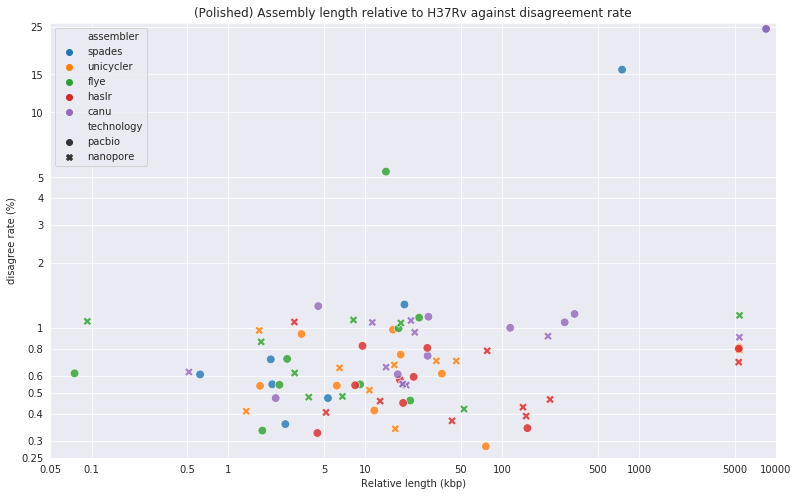

In [224]:
x = "relative_total_length"
y = "disagree_rate"
hue = "assembler"
style = "technology"
fig, ax = plt.subplots(figsize=FIGSIZE)
ax = sns.scatterplot(
    x=x, 
    y=y, 
    data=polished_df, 
    hue=hue,
    style=style,
    ax=ax,
    s=75,
    alpha=0.8
)
# ax = sns.swarmplot(
#     x=x, 
#     y=y, 
#     hue=hue,
#     data=polished_df, 
#     ax=ax,
#     dodge=True,
#     color="white"
# )
ax.set(title="(Polished) Assembly length relative to H37Rv against disagreement rate")
_ = ax.set_xlabel("Relative length (kbp)")
ax.set_xscale("log")
ax.set_yscale("log")

log_ticks = [0.05, 0.1, 0.5, 1, 5, 10, 50, 100, 500, 1000, 5000, 10000]
ax.set_xticks(log_ticks)
_ = ax.set_xticklabels(log_ticks)
_ = ax.set_xlim((log_ticks[0], log_ticks[-1]))
ax.set_ylabel("disagree rate (%)")
log_ticks = [0.25, 0.3, 0.4, 0.5, 0.6, 0.8, 1, 2, 3, 4, 5, 10, 15, 25]
ax.set_yticks(log_ticks)
_ = ax.set_yticklabels(log_ticks)
_ = ax.set_ylim((0.25, 26))
# Put the legend out of the figure
# _ = plt.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.)